In [1]:
import pickle
from pathlib import Path
from gensim.models import Word2Vec
from gensim.models.phrases import Phraser

data_dir = Path(r"c:\Users\cyyua\DS\word_embedding\processed_comments\wikipedia_processed")
corpus_path = data_dir / "processed_corpus_stopwords.pkl"

with corpus_path.open("rb") as f:
    sentences = pickle.load(f)

bigram_path = "../../models/bigram/all_bigram_1.phr"
bigram_model = Phraser.load(str(bigram_path))
sentences = [bigram_model[sent] for sent in sentences]

model = Word2Vec(
    sentences=sentences,
    vector_size=300,
    window=5,
    min_count=10,
    workers=16,
    sg=0,
    epochs=10,
)

model_dir = Path(r"c:\Users\cyyua\DS\word_embedding\models\neutral")
model_dir.mkdir(parents=True, exist_ok=True)
# convert Path to str because gensim expects a filename string (it calls .endswith internally)
model.save(str(model_dir / "neutral_2.model"))

In [2]:
import numpy as np
import pandas as pd
import gensim
from sklearn.metrics.pairwise import cosine_similarity
import os
import matplotlib.pyplot as plt

def compare_subreddit_embeddings_by_period(model1, model2, subreddit1_name, subreddit2_name, time_period, output_file=None):
    """Compare two word2vec models by aligning their vector spaces and measuring word similarities"""
    # Find common vocabulary
    vocab1 = set(model1.wv.index_to_key)
    vocab2 = set(model2.wv.index_to_key)
    common_vocab = list(vocab1.intersection(vocab2))

    print(f"{time_period}: Common vocabulary between {subreddit1_name} and {subreddit2_name}: {len(common_vocab)} words")
    
    # Extract embeddings for common words
    vectors1 = np.array([model1.wv[word] for word in common_vocab])
    vectors2 = np.array([model2.wv[word] for word in common_vocab])
    
    # Mean center
    vectors1 = vectors1 - vectors1.mean(axis=0, keepdims=True)
    vectors2 = vectors2 - vectors2.mean(axis=0, keepdims=True)

    # Normalize each vector to unit length
    vectors1 = vectors1 / np.linalg.norm(vectors1, axis=1, keepdims=True)
    vectors2 = vectors2 / np.linalg.norm(vectors2, axis=1, keepdims=True)
    
    # Compute the best rotational alignment (orthogonal Procrustes)
    m = vectors1.T @ vectors2
    u, _, vt = np.linalg.svd(m)
    rotation = u @ vt
    
    # Apply rotation to align model2's space with model1's space
    vectors2_aligned = vectors2 @ rotation
    
    # Calculate word by word similarities
    similarities = []
    for i, word in enumerate(common_vocab):
        sim = cosine_similarity(vectors1[i].reshape(1, -1), 
                                vectors2_aligned[i].reshape(1, -1))[0][0]
        similarities.append((word, sim))
    
    # Create DataFrame
    df = pd.DataFrame(similarities, columns=['word', 'similarity'])
    
    # Sort by similarity (most different words first)
    df = df.sort_values('similarity')
    
    # Save to file if requested
    if output_file:
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(output_file), exist_ok=True)
        df.to_csv(output_file, index=False)
    
    return df

# Define input directory where models are stored
input_dir = "../../models/chunk_3"
# Define output directory
output_dir = "../../output/neutral_2"
os.makedirs(output_dir, exist_ok=True)

periods = ["before_2016", "2017_2020", "2021_2024"]
# Load all models into a dict for easy access
model_names = ["democrats", "republican"]
models = {}
for name in model_names:
    models[name] = {}
    for period in periods:
        models[name][period] = gensim.models.Word2Vec.load(f"{input_dir}/{name}_{period}.model")
neutral_model = gensim.models.Word2Vec.load(str(model_dir / "neutral_2.model"))



In [3]:
for period in periods:
        output_file = f"{output_dir}/republican_neutral_{period}.csv"
        compare_subreddit_embeddings_by_period(
            models['republican'][period],
            neutral_model,
            'republican',
            'neutral',
            period,
            output_file=output_file
        )

before_2016: Common vocabulary between republican and neutral: 13203 words
2017_2020: Common vocabulary between republican and neutral: 13729 words
2021_2024: Common vocabulary between republican and neutral: 15042 words


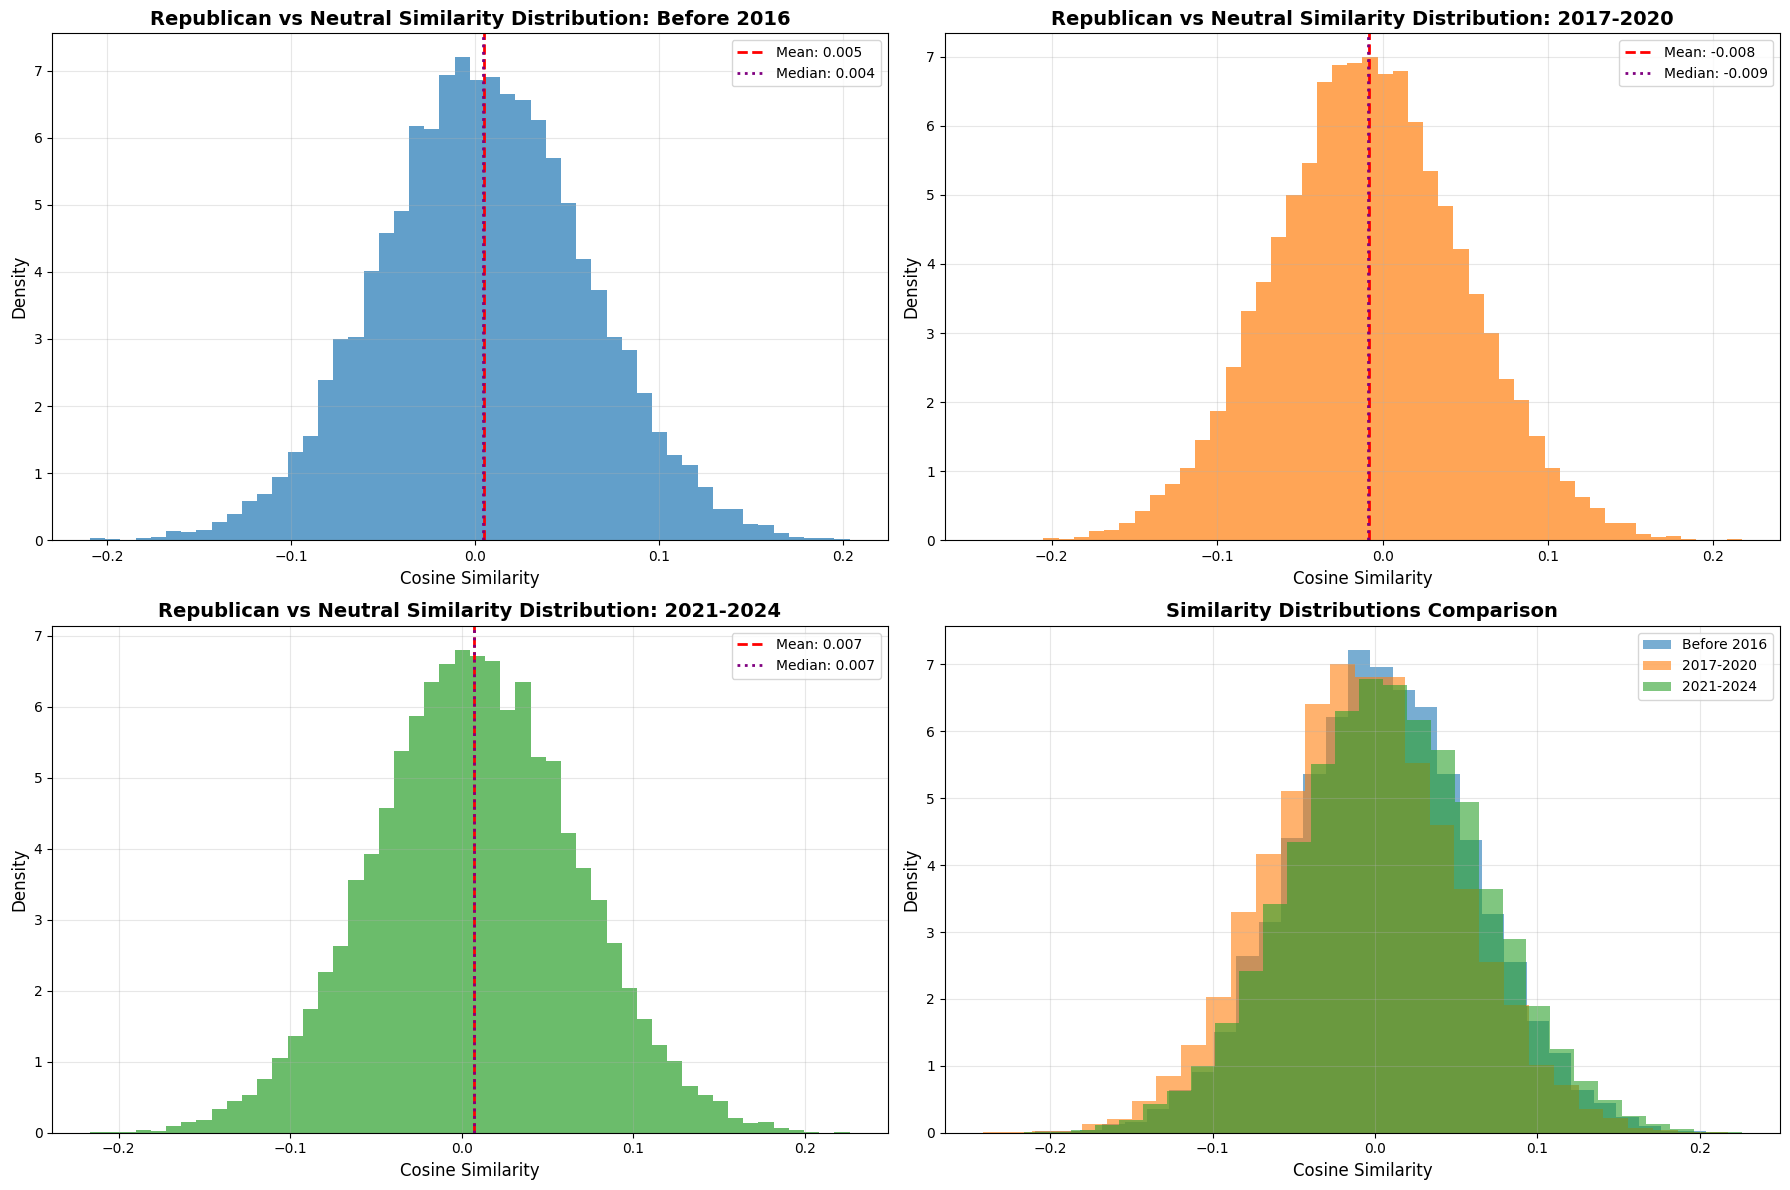

FileNotFoundError: [Errno 2] No such file or directory: '../../output/neutral_2/democrats_neutral_before_2016.csv'

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def analyze_similarity_distributions(output_dir, df_before_2016, df_2017_2020, df_2021_2024, subreddit1, subreddit2):
    """Analyze how cosine similarity distributions change over time"""
    
    # Prepare data
    dataframes = [df_before_2016, df_2017_2020, df_2021_2024]
    period_names = ['Before 2016', '2017-2020', '2021-2024']
    
    # Create the plot
    plt.figure(figsize=(18, 12))
    
    # Main distribution plots
    for i, (df, period) in enumerate(zip(dataframes, period_names)):
        plt.subplot(2, 2, i+1)
        
        # Create histogram
        plt.hist(df['similarity'], bins=50, alpha=0.7, density=True, 
                color=['#1f77b4', '#ff7f0e', '#2ca02c'][i])
        
        # Add statistics
        mean_sim = df['similarity'].mean()
        median_sim = df['similarity'].median()
        
        plt.axvline(mean_sim, color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {mean_sim:.3f}')
        plt.axvline(median_sim, color='purple', linestyle=':', linewidth=2,
                   label=f'Median: {median_sim:.3f}')

        plt.title(f'{subreddit1} vs {subreddit2} Similarity Distribution: {period}', fontsize=14, fontweight='bold')
        plt.xlabel('Cosine Similarity', fontsize=12)
        plt.ylabel('Density', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # Combined comparison plot
    plt.subplot(2, 2, 4)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    for i, (df, period, color) in enumerate(zip(dataframes, period_names, colors)):
        plt.hist(df['similarity'], bins=30, alpha=0.6, density=True, 
                label=period, color=color)
    
    plt.title('Similarity Distributions Comparison', fontsize=14, fontweight='bold')
    plt.xlabel('Cosine Similarity', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{subreddit1}_{subreddit2}_similarity_distributions.png")
    plt.show()


input_dir = "../../output/neutral_2"
# Run the analysis
subreddit_pairs = [
    ("republican", "neutral"),
    ("democrats", "neutral")
]
periods = ["before_2016", "2017_2020", "2021_2024"]

for sub1, sub2 in subreddit_pairs:
    dfs = []
    for period in periods:
        csv_path = f"{input_dir}/{sub1}_{sub2}_{period}.csv"
        dfs.append(pd.read_csv(csv_path))
    analyze_similarity_distributions(
        input_dir,
        dfs[0], dfs[1], dfs[2],
        sub1.capitalize(), sub2.capitalize()
    )